# Homework 3: MNIST Image Classifer

Building a simple image classifier from scratch, classifying images of digits. A lower loss value means a more accurate model, so I will be comparing two models: a single layer model and a multi-layer model, and evaluating which one can acheive a lower loss.

## Setup

Necessary imports and loading in images into training data and validation data.

In [1]:
# Import fastai, but only for the DataBlock part.
from fastai.vision.all import *

path = untar_data(URLs.MNIST)

# Create a subset of the images, so we train faster. We do this by taking 500 random images of each digit.
set_seed(0)
num_imgs_per_digit = 500
items = [
    p
    for split in ['training', 'testing']
    for digit in range(10)
    for p in (path/split/str(digit)).ls().shuffle()[:num_imgs_per_digit]
]

# Create the `dataloaders`. We need a slightly special `ImageBlock` because we want grayscale images.

block = DataBlock(
    blocks=(ImageBlock(PILImageBW), CategoryBlock),
    get_y = parent_label,
    splitter=GrandparentSplitter(train_name='training', valid_name="testing"),
)
dataloaders = block.dataloaders(items, bs=16)
print(f"{dataloaders.train.n} training images, {dataloaders.valid.n} validation images")

5000 training images, 5000 validation images


## Single Layer Model

First is a single layer model/logistic regression. 

In [2]:
# Flatten each image, removing the spacial structure
flattener = nn.Flatten()

# Create the linear layer
linear_1 = nn.Linear(in_features=784, out_features=10, bias=False)

In [3]:
# Create model for single linear layer
model_1 = nn.Sequential(
    flattener,
    linear_1,
)
model_1.to(dataloaders.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=False)
)

Epoch  0: loss=0.58, train accuracy 4094/4992
Epoch  0: loss=0.58, validation accuracy:0.8841999769210815 
Epoch  1: loss=0.47, train accuracy 4457/4992
Epoch  1: loss=0.47, validation accuracy:0.902999997138977 
Epoch  2: loss=0.42, train accuracy 4541/4992
Epoch  2: loss=0.42, validation accuracy:0.8881999850273132 
Epoch  3: loss=0.39, train accuracy 4564/4992
Epoch  3: loss=0.39, validation accuracy:0.8962000012397766 
Epoch  4: loss=0.36, train accuracy 4597/4992
Epoch  4: loss=0.36, validation accuracy:0.9019999504089355 
Epoch  5: loss=0.34, train accuracy 4621/4992
Epoch  5: loss=0.34, validation accuracy:0.9052000045776367 
Epoch  6: loss=0.33, train accuracy 4638/4992
Epoch  6: loss=0.33, validation accuracy:0.897599995136261 
Epoch  7: loss=0.32, train accuracy 4643/4992
Epoch  7: loss=0.32, validation accuracy:0.8987999558448792 
Epoch  8: loss=0.30, train accuracy 4700/4992
Epoch  8: loss=0.30, validation accuracy:0.9083999991416931 
Epoch  9: loss=0.29, train accuracy 470

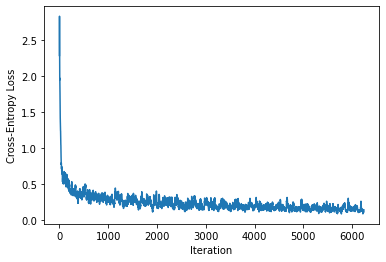

In [4]:
num_epochs=20
learning_rate=0.3
losses=[]

linear_1.reset_parameters()

for epoch in range(num_epochs):
    total_images = 0
    total_correct = 0
    
    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_1(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        loss.backward()
        for parameter in model_1.parameters():
            parameter.data -= learning_rate * parameter.grad
        model_1.zero_grad()
        
        # Track the metrics of the model for training
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate
        
        losses.append(loss.item())
    
    # check the validation accuracy for this epoch
    total_images_valid = 0
    total_correct_valid = 0
    
    for images, labels in dataloaders.valid:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_1(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        # Track the metrics of the model on the validation set
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_valid += len(labels)
        total_correct_valid += num_accurate
        
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, train accuracy {total_correct:3d}/{total_images}")
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, validation accuracy:{total_correct_valid/total_images_valid} ")

    
# Plot the smoothed loss
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

## Two-Layer Model

Next is a two-layer model, with a ReLU layer in between the linear layers.

In [5]:
# Defining the layers
linear_1 = nn.Linear(in_features=784, out_features=30)
relu_layer = nn.ReLU()
linear_2 = nn.Linear(in_features=30, out_features=10)

In [6]:
# Create two-layer model
model_2 = nn.Sequential(
    flattener,
    linear_1,
    relu_layer,
    linear_2
)
model_2.to(dataloaders.device)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=30, bias=True)
  (2): ReLU()
  (3): Linear(in_features=30, out_features=10, bias=True)
)

Epoch  0: loss=0.69, training accuracy: 3859/4992
Epoch  0: loss=0.69, validation accuracy:0.8980000019073486
Epoch  1: loss=0.51, training accuracy: 4465/4992
Epoch  1: loss=0.51, validation accuracy:0.8867999911308289
Epoch  2: loss=0.43, training accuracy: 4589/4992
Epoch  2: loss=0.43, validation accuracy:0.8921999931335449
Epoch  3: loss=0.37, training accuracy: 4715/4992
Epoch  3: loss=0.37, validation accuracy:0.9247999787330627
Epoch  4: loss=0.32, training accuracy: 4723/4992
Epoch  4: loss=0.32, validation accuracy:0.9307999610900879
Epoch  5: loss=0.29, training accuracy: 4789/4992
Epoch  5: loss=0.29, validation accuracy:0.9343999624252319
Epoch  6: loss=0.27, training accuracy: 4814/4992
Epoch  6: loss=0.27, validation accuracy:0.9289999604225159
Epoch  7: loss=0.24, training accuracy: 4861/4992
Epoch  7: loss=0.24, validation accuracy:0.9305999875068665
Epoch  8: loss=0.22, training accuracy: 4904/4992
Epoch  8: loss=0.22, validation accuracy:0.936199963092804
Epoch  9: l

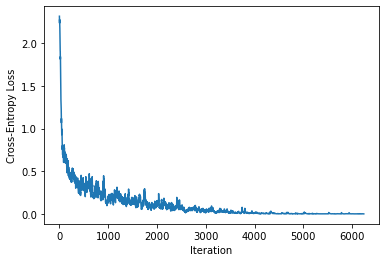

In [7]:
num_epochs=20
learning_rate=0.3
losses=[]

linear_1.reset_parameters()
linear_2.reset_parameters()

for epoch in range(num_epochs):
    total_images = 0
    total_correct = 0
    
    for images, labels in dataloaders.train:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_2(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        loss.backward()
        for parameter in model_2.parameters():
            parameter.data -= learning_rate * parameter.grad
        model_2.zero_grad()
        
        # Track the metrics of the model
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images += len(labels)
        total_correct += num_accurate
        
        losses.append(loss.item())
        
    total_images_valid = 0
    total_correct_valid = 0
    
    for images, labels in dataloaders.valid:
        images = cast(images, Tensor)
        labels = cast(labels, Tensor)
        
        logits = model_2(images)
        loss = F.cross_entropy(logits, labels, reduction='none').mean()
        
        # Track the metrics of the model
        predictions = logits.argmax(axis=1)
        num_accurate = (predictions == labels).sum()
        total_images_valid += len(labels)
        total_correct_valid += num_accurate
        
    avg_loss_this_epoch = np.mean(losses[-total_images:])
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, training accuracy: {total_correct:3d}/{total_images}")
    print(f"Epoch {epoch:2d}: loss={avg_loss_this_epoch:.2f}, validation accuracy:{total_correct_valid/total_images_valid}")

# Plot the smoothed loss
pd.Series(losses).ewm(alpha = .1).mean().plot()
plt.xlabel("Iteration")
plt.ylabel("Cross-Entropy Loss");

## Analysis/Reflection

With around 0.04 as the loss for the two-layer model, and around 0.21 for the logistic regression model, the two layer model did significantly better than the single layer model. I found that for both models, a learning rate of 0.3 was appropriate, and also used 20 epochs for each. 

**- What did you learn about neural networks from this exercise?**

I mostly learned about the impressive capabilities of a neural network compared to linear regression. I also learned some about picking learning rates/epochs, as I had to decide which rates worked best.

**- What did you learn about your own problem-solving process?**

I learned that I rely a lot on the notebooks from class rather than materials online. I found the lab 5 mnist classifier to be helpful. This also made me less likely to look up specific functions of PyTorch and understand them on a deeper level, so on my own time I might want to try some of the optional extensions to this homework.

**- How would you describe this experience in a job interview?**

In a job interview, I would probably talk about the differences between creating a linear model and a two-layer model, and how the results ended up as they did, and then what I learned from those results.